# Machine Learning 

In [2]:
from math import floor

In [3]:
import pandas as pd

**pandas** is a Python package that is designed for data analysis and data manipulation. It is used to process the *csv*  (comma separated value) files into **DataFrame** data structures. **DataFrame** are two-dimensional, two-dimensional mutable data structures with row and column labels. This is particularly useful for the data analysis of data which contain *features* and *labels*. 

In [4]:
import re

**re** (regular expression) is a Python package that that searches for matching patterns in string. It contains numerous special characters which can be used to specify the type of search and are used to modfiy to split string.

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**nltk** (natural language toolkit) is a Python package that that contains libraries specialized for natural language processing. One particular useful library is the stopwords library containing the most common words in a language such as *i*, *you*, *he*, *were*, *again*.

In [6]:
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

**bs4** (BeautifulSoup4) is a Python package that parses through HTML and XML files. It can be used to navigate the nested structure of these files and reference specific content. The library also supports formatted printing of such files.

In [7]:
file_names = ('Youtube01-Psy.csv', 'Youtube02-KatyPerry.csv',
             'Youtube03-LMFAO.csv', 'Youtube04-Eminem.csv',
             'Youtube05-Shakira.csv')

These are the five files taken from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/YouTube+Spam+Collection) which contain the youtube comments. Each row of data contains information on the following:  
* Comment ID
* Author
* Date
* Content
* Class

The breakdown of data is as follows:

|Dataset|Youtube ID|Spam|Ham|Total
|:------|:---------|:--:|:-:|:---:| 
|Psy|9bZkp7q19f0|175|175|350|
|KatyPerry|CevxZvSJLk8|175|175|350|
|LMFAO|KQ6zr6kCPj8|236|202|438|
|Eminem|uelHwf8o7_U|245|203|448|
|Shakira|pRpeEdMmmQ0|174|196|370|
||||**Total**|1956|

In [8]:
def readCSV(file_name):
    '''This function iterates through the list of file names and 
    drops the irrelevant features, retaining the CONTENT and CLASS. It returns a
    DataFrame of the data'''
    data = pd.read_csv(file_name)
    data = data.drop(['COMMENT_ID', 'DATE', 'AUTHOR'], axis=1)
    return data

In [9]:
def test_data(data):
    '''This function selects 30% of each type for testing purposes.'''
    test = floor(len(data.index) * 0.30)
    ham_data = data[data.CLASS == 0].iloc[0:test, :]
    spam_data = data[data.CLASS == 1].iloc[0:test, :]
    return pd.concat([ham_data, spam_data])

In [28]:
def train_data(data):
    '''This function selects 70% of each label type for training purposes'''
    test = floor(len(data.index) * 0.30)
    ham_data = data[data.CLASS == 0].iloc[test:, :]
    spam_data = data[data.CLASS == 1].iloc[test:, :]
    return pd.concat([ham_data, spam_data])

In [11]:
def remove_html(content):
    '''This function removes extra html tags'''
    return  BeautifulSoup(content, "html.parser").get_text()

In [12]:
def keep_alpha(content):
    '''This function retains all alpha-characters, replacing invalid characters with spaces'''
    return re.sub("[^a-zA-Z]", " ", content)

In [13]:
def lower(content):
    '''This function converts all characters to lowercase to allow for
    uniform word checking, removing the need to check for both capital and lowercase
    verisions of words'''
    return content.lower()

In [14]:
def split_list(content):
    '''This function converts a string to a list, separating words into individual elements
    at each whitespace'''
    return content.split()

In [15]:
def remove_stopwords(content):
    '''This function removes stopwords from the current list of words'''
    return [w for w in content if not w in stopwords.words('english')]

In [83]:
def clean_content(content):
    '''This function cleans up the raw comment, returning a list of sanitized words'''
    return remove_stopwords(split_list(lower(keep_alpha(remove_html(content)))))

In [29]:
def train(trainData):
    '''This function trains the classifier, iterating through each row of the DataFrame.
    It totals up the number of spam and ham comments, the percentage of spam and ham comments, and
    processes each comment.'''
    global spam_count, ham_count, total
    global spam_per, ham_per
    for index, data in trainData.iterrows():
        if data['CLASS'] == 1:
            spam_count += 1
        else:
            ham_count += 1
        processContent(data['CONTENT'], data['CLASS'])
        total += 1
    
    spam_per = spam_count / total
    ham_per = ham_count / total

In [18]:
def processContent(content, label):
    '''This function processes the content, updating a dictionary which stores
    the frequency of words beloging to a Ham or Spam label.'''
    global spamWords, hamWords
    global positive_count, negative_count
    content = clean_content(content)
    for word in content:
        if label == 1:
            spamWords[word] = spamWords.get(word, 0) + 1
            positive_count += 1
        elif label == 0:
            hamWords[word] = hamWords.get(word, 0) + 1            
            negative_count += 1

In [19]:
def probabilityWord(word, label):
    if label == 1:
        return spamWords.get(word, 1) / positive_count
    return hamWords.get(word, 1) / negative_count

In [20]:
def probabilityContent(content, label):
    content = clean_content(content)
    result = 1.0
    for word in content:
        result *= probabilityWord(word, label)
    return result

In [21]:
def classifier(content):
    global spam_per, ham_per
    spam_prob = spam_per * probabilityContent(content, 1)
    ham_prob = ham_per * probabilityContent(content, 0)
    return spam_prob > ham_prob

In [22]:
spam_count, ham_count, total = 0, 0, 0
spam_per, ham_per = 0.0, 0.0
spamWords, hamWords = {}, {}
positive_count, negative_count = 0, 0
testing_data = []
for file_name in file_names:
    data = readCSV(file_name)    
    testData = test_data(data)
    trainData = train_data(data)
    train(trainData)
    testing_data.append(testData)

In [84]:
spam_correct, spam_wrong, spam_total = 0, 0, 0
ham_correct, ham_wrong, ham_total = 0, 0, 0
for testData in testing_data:
    for index, data in testData.iterrows():
        total += 1
        label = 1 if classifier(data['CONTENT']) else 0
        if data['CLASS'] == 0:
            if label == 0:
                ham_correct += 1
            else:
                ham_wrong += 1
            ham_total += 1
        else:
            if label == 1:
                spam_correct += 1
            else:
                spam_wrong += 1
            spam_total += 1
            
total_spam = spam_correct + ham_wrong
total_ham = spam_wrong + ham_correct
total_total = spam_total + ham_total

In [85]:
print("Type\tSpam\tHam\tTotal")
print("Spam:\t{}\t{}\t{}\t{:.4}".format(spam_correct, spam_wrong, spam_total, spam_correct/spam_total))
print("Ham:\t{}\t{}\t{}\t{:.4}".format(ham_wrong, ham_correct, ham_total, ham_correct/ham_total))
print("Total\t{}\t{}\t{}".format(total_spam, total_ham, total_total))
print("\t{:.4}\t{:.4}\t\t{:.4}".format(spam_correct / total_spam, ham_correct / total_ham, (spam_correct + ham_correct)/ total_total))

Type	Spam	Ham	Total
Spam:	410	176	586	0.6997
Ham:	23	563	586	0.9608
Total	433	739	1172
	0.9469	0.7618		0.8302


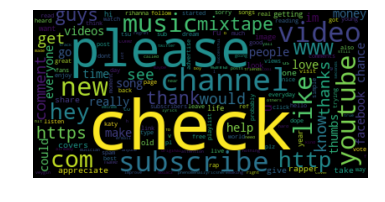

In [74]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=spamWords)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

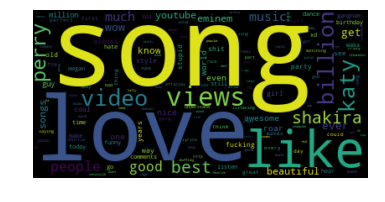

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=hamWords)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
# from lxml import html
# from lxml.html import fromstring, tostring
# from selenium import webdriver
# from selenium.webdriver.common.by import By
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
# def check_link(url):
#     options = webdriver.ChromeOptions()
#     # options.add_argument('headless')
#     browser = webdriver.Chrome(chrome_options = options)
#     browser.get(url)
#     browser.maximize_window()
#     browser.execute_script("window.scrollTo(0, 1000);")
#     WebDriverWait(browser, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "yt-sort-filter-sub-menu-renderer")))
#     doc = fromstring(browser.page_source)
#     browser.quit()


#     comments = doc.xpath('//*[@id="content-text"]')
#     for comment in comments:
#         if comment.xpath("text()"):
#             content = str(comment.xpath("text()")[0])
#             label = "SPAM" if classifier(content) else "HAM"
#             print(label + ": " + content)
            

In [ ]:
# print(sorted(spamWords.items(), key=lambda kv: kv[1], reverse=True))

In [82]:
# print(sorted(hamWords.items(), key=lambda kv: kv[1], reverse=True))


In [27]:
%%latex
\[P(A|B)=\frac{P(B|A)P(A)}{P(B)}\]

<IPython.core.display.Latex object>